Endomondo was a social fitness network created by Endomondo LLC which allowed users to track their fitness and health statistics with a mobile application. 

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 41 kB/s 
     |████████████████████████████████| 199 kB 49.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845513 sha256=2eccd83b036194f4baec1e002f4269b6733408fec5f2e27c4c7109e09bccf7ab
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


In [2]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
,isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

In [3]:
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixictly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [4]:
MAX_MEMORY = '15G'

#initializing a spark session
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
  
def init_spark():
    spark = SparkSession.builder.appName("Pyspark guide").config(conf=conf).getOrCreate()
    return spark

In [5]:
spark = init_spark()

In [6]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [7]:
df = spark.read.json("/content/drive/MyDrive/endomondoHR_proper.json", mode = "DROPMALFORMED")
# Dataset https://sites.google.com/eng.ucsd.edu/fitrec-project/home

In [8]:
print("df type:", str(type(df)))

df type: <class 'pyspark.sql.dataframe.DataFrame'>


Overview

In [9]:
print("Overview")
df.printSchema()
print("Columns overview")
pd.DataFrame(df.dtypes, columns = ['Col Name', 'Data types'])

Overview
root
 |-- altitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- gender: string (nullable = true)
 |-- heart_rate: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- id: long (nullable = true)
 |-- latitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- longitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- speed: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- sport: string (nullable = true)
 |-- timestamp: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- url: string (nullable = true)
 |-- userId: long (nullable = true)

Columns overview


,Col Name,Data types
0,altitude,array<double>
1,gender,string
2,heart_rate,array<bigint>
3,id,bigint
4,latitude,array<double>
5,longitude,array<double>
6,speed,array<double>
7,sport,string
8,timestamp,array<bigint>
9,url,string


Description

In [10]:
#description
df.describe().toPandas()

,summary,gender,id,sport,url,userId
0,count,167783,167783,167783,167783,167783
1,mean,None,3.614780933983598E8,None,None,4565819.273555724
2,stddev,None,1.571586171633681E8,None,None,3906676.555400663
3,min,female,257936,aerobics,https://www.endomondo.com/users/10014612/worko...,69
4,max,unknown,674007977,yoga,https://www.endomondo.com/users/9991401/workou...,15481421


In [11]:
df.limit(5).toPandas()  #checking first 5 rows

,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId
0,"[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....",male,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",396826535,"[60.173348765820265, 60.173239801079035, 60.17...","[24.64977040886879, 24.65014273300767, 24.6509...","[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...",bike,"[1408898746, 1408898754, 1408898765, 140889877...",https://www.endomondo.com/users/10921915/worko...,10921915
1,"[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....",male,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",392337038,"[60.173247596248984, 60.17320962622762, 60.172...","[24.649855233728886, 24.65015547350049, 24.650...","[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...",bike,"[1408221682, 1408221687, 1408221699, 140822170...",https://www.endomondo.com/users/10921915/worko...,10921915
2,"[76.4, 73.2, 72.4, 73.0, 73.0, 70.8, 69.2, 69....",male,"[99, 105, 113, 110, 109, 110, 108, 121, 116, 1...",389643739,"[60.17326201312244, 60.173205351457, 60.172969...","[24.64995657093823, 24.650197718292475, 24.651...","[4.0464, 13.8204, 16.9776, 19.9404, 28.7856, 3...",bike,"[1407858459, 1407858466, 1407858478, 140785849...",https://www.endomondo.com/users/10921915/worko...,10921915
3,"[28.6, 29.4, 29.4, 29.4, 28.0, 27.0, 25.2, 23....",male,"[99, 105, 113, 109, 112, 116, 116, 114, 114, 1...",386729739,"[60.173286236822605, 60.17323946580291, 60.173...","[24.649874344468117, 24.650242729112506, 24.65...","[7.4988, 15.4008, 17.8668, 21.5712, 24.1416, 3...",bike,"[1407432042, 1407432048, 1407432056, 140743206...",https://www.endomondo.com/users/10921915/worko...,10921915
4,"[32.0, 32.0, 32.0, 35.8, 36.2, 36.2, 36.2, 36....",male,"[110, 113, 114, 116, 123, 126, 129, 135, 137, ...",383186560,"[60.17329327762127, 60.17327332869172, 60.1732...","[24.64979832060635, 24.64992195367813, 24.6500...",None,bike (transport),"[1406909434, 1406909436, 1406909437, 140690943...",https://www.endomondo.com/users/10921915/worko...,10921915


In [12]:
string_columns = ['gender', 'sport', 'url']
numeric_columns = ['id','userId']
array_columns = ['altitude', 'heart_rate', 'latitude', 'longitude', 'speed', 'timestamp']

Checking missing values

In [13]:
missing_values = {}
for index, column in enumerate(df.columns):
    if column in string_columns:
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count() # count where None and null values are present
        missing_values.update({column:missing_count})
    if column in numeric_columns:  
        missing_count = df.where(col(column).isin([0,None,np.nan])).count() # count where 0, None and null values are present
        missing_values.update({column:missing_count})
    if column in array_columns:  
        missing_count = df.filter(array_contains(df[column], 0) | array_contains(df[column], np.nan)).count() # count where 0 and null values are present
        missing_values.update({column:missing_count})

missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId
0,29129,0,512,0,67,67,4845,0,0,0,0


In [14]:
# We create new column to count the number of timestamps recorded per row/workout, named as 'PerWorkoutRecordCount' column
df = df.withColumn('PerWorkoutRecordCount', size(col('timestamp')))
def user_activity_workout_summarize(df):
    user_count = format(df.select('userId').distinct().count(), ',d')
    workout_count = format(df.select('id').distinct().count(), ',d')
    activity_count = str(df.select('sport').distinct().count())
    sum_temp = df.agg(functions.sum('PerWorkoutRecordCount')).toPandas()
    total_records_count = format(sum_temp['sum(PerWorkoutRecordCount)'][0],',d')
    columns=['Users count', 'Activity types count','Workouts count', 'Total records count']
    data = [[user_count], [activity_count], [workout_count], [total_records_count]]
    sum_dict = {column: data[i] for i, column in enumerate(columns)}
    sum_df = pd.DataFrame.from_dict(sum_dict)[columns]
    gender_user_count = df.select('gender','userId').distinct().groupBy('gender').count().toPandas()
    gender_activities_count = df.groupBy('gender').count().toPandas()
    gender_user_activity_count = gender_user_count.join(gender_activities_count.set_index('gender'), on='gender', how='inner', lsuffix='_gu')
    gender_user_activity_count.columns = ['Gender', '# of users', 'Activities (workouts) count']
    
    return sum_df, gender_user_activity_count

sum_dfs= user_activity_workout_summarize(df)
print('\nOverall data set summary on users, workouts and number of records (pre-filtering):')
sum_dfs[0]


Overall data set summary on users, workouts and number of records (pre-filtering):


,Users count,Activity types count,Workouts count,Total records count
0,"1,059",43,"167,783","83,891,500"


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [15]:
ranked_sport_users_df = df.select(df.sport, df.userId).distinct().groupBy(df.sport).count().orderBy("count", ascending=False)

# Top 5 workout types
highest_sport_users_df = ranked_sport_users_df.limit(5).toPandas()
# Rename column name : 'count' --> Users count
highest_sport_users_df.rename(columns = {'count':'Users count'}, inplace = True)
# Caculate the total users
total_sports_users = ranked_sport_users_df.groupBy().sum().collect()[0][0]

In [16]:
ranked_sport_users_df.collect()[:5] #retrieving all the elements of sports and user id counts upto top 5

[Row(sport='run', count=807),
 Row(sport='bike', count=762),
 Row(sport='mountain bike', count=320),
 Row(sport='bike (transport)', count=194),
 Row(sport='indoor cycling', count=135)]

##Exploratory Data Analysis

#### Computing the percentage of top 5 workout type / total users

Top 5 sports that have the most users participated:


,sport,Users count,percentage
0,run,807,28.286015
1,bike,762,26.708728
2,mountain bike,320,11.216264
3,bike (transport),194,6.799860
4,indoor cycling,135,4.731861
5,others,635,22.257273


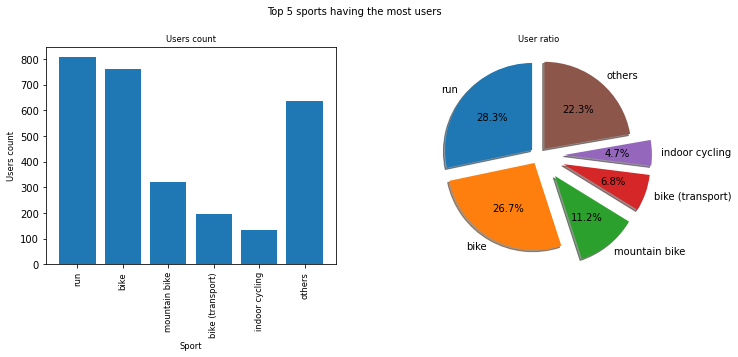

In [17]:
highest_sport_users_df_renamed = highest_sport_users_df
highest_sport_users_df_renamed['percentage'] = highest_sport_users_df['Users count']/ total_sports_users * 100

# We assign the rest of users belong to another specific group that we can say 'others'
others = {
      'sport': 'others'
    , 'Users count': total_sports_users - sum(highest_sport_users_df_renamed['Users count'])
    , 'percentage': 100 - sum(highest_sport_users_df_renamed['percentage'])
}

highest_sport_users_df_renamed = highest_sport_users_df_renamed.append(
    others, ignore_index=True
)
print('Top 5 sports that have the most users participated:')
highest_sport_users_df_renamed

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 =   axs[0].bar(x=highest_sport_users_df_renamed['sport']
                     , height=highest_sport_users_df_renamed['Users count'])
title0 =  axs[0].set_title('Users count', fontsize = 'small')
xlabel0 = axs[0].set_xlabel('Sport', fontsize = 'small')
ylabel0 = axs[0].set_ylabel('Users count', fontsize = 'small')
xsticks_label = axs[0].set_xticklabels(highest_sport_users_df_renamed['sport'] 
                                       ,rotation = 'vertical', fontsize='small')
explode = (0.1, 0.1, 0.3, 0.3, 0.3, 0.1)
title1 = axs[1].set_title('User ratio', fontsize = 'small')
plot1 = axs[1].pie(
      x=highest_sport_users_df_renamed['percentage']
    , labels=highest_sport_users_df_renamed['sport']
    , autopct='%1.1f%%', shadow=True, explode=explode, startangle=90
    , radius=1
)

text = fig.text(0.5, 1.02, 'Top 5 sports having the most users', ha='center', va='top', transform=fig.transFigure)

In [18]:
#activities by gender
activities_by_gender = df.groupBy('sport', 'gender').count().toPandas() 
activities_by_gender[:5]

,sport,gender,count
0,core stability training,male,400
1,run,male,64548
2,kayaking,male,90
3,mountain bike,male,10362
4,cross-country skiing,male,622


There are total: 43 activities and here is the chart for activities based on gender:


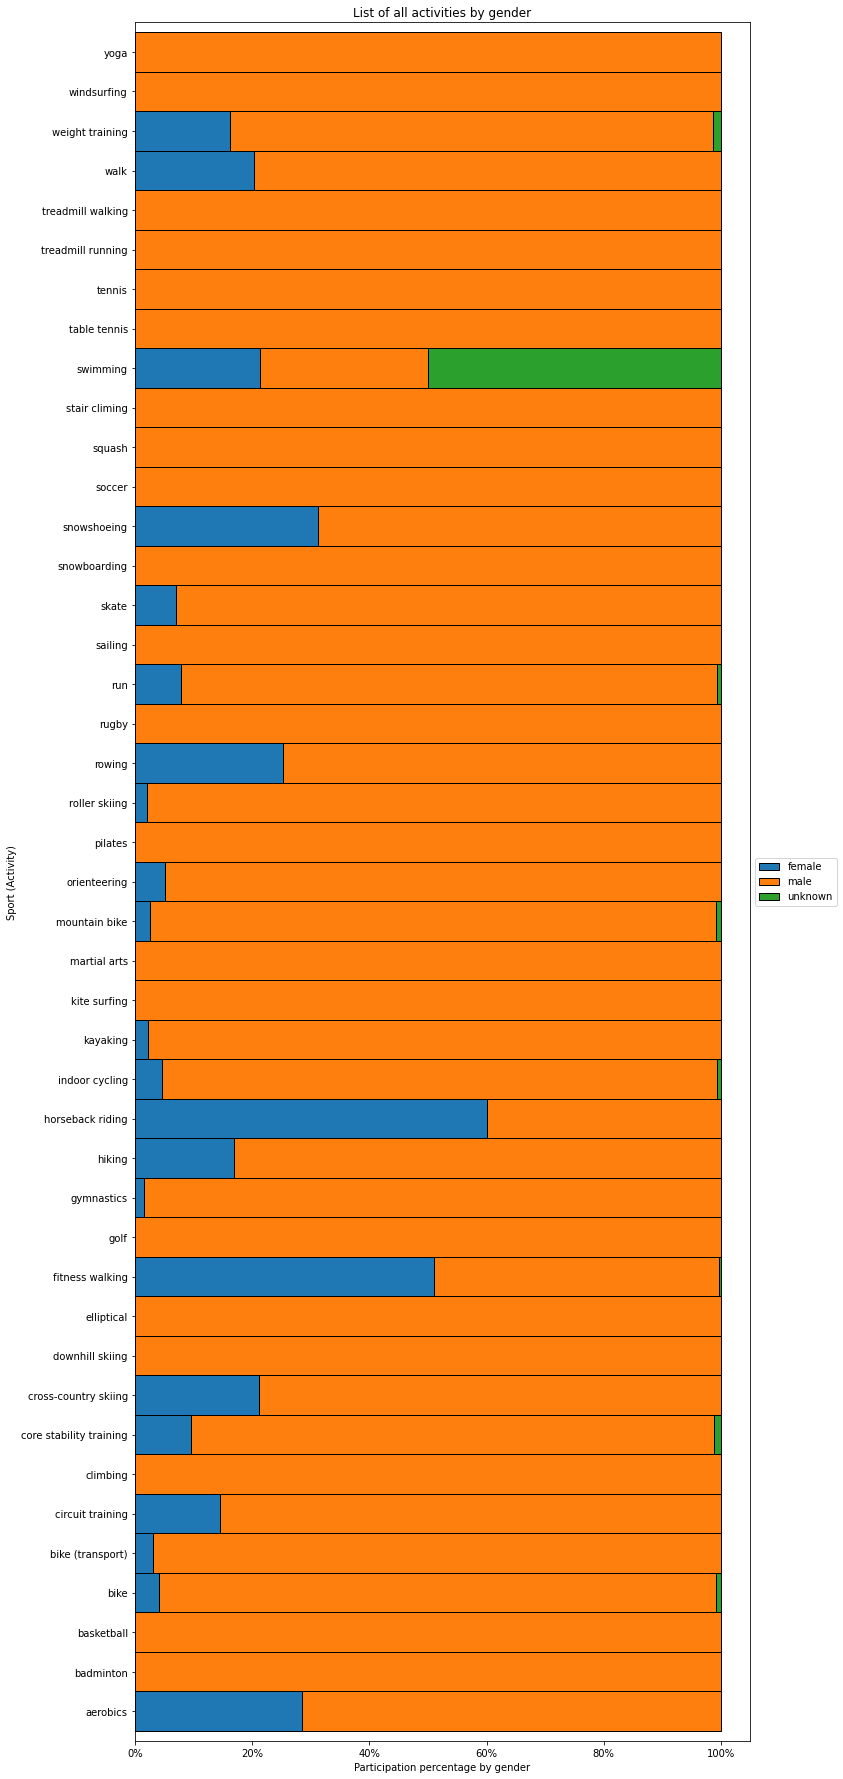

In [19]:
total_activities = ranked_sport_users_df.count()
print(f'There are total: {total_activities} activities and here is the chart for activities based on gender:')
# Adding activities based on gender
activities_by_gender = df.groupBy('sport', 'gender').count().toPandas()
# Visualization
fig = plt.figure(figsize=(12, 25))
grid_size = (1,1);
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
plot = activities_by_gender.groupby(['sport', 'gender']).agg(np.mean).groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', stacked=True, width=1  ## APPLY UNSTACK TO RESHAPE DATA
                , edgecolor='black', ax=ax, title='List of all activities by gender')
ylabel = plt.ylabel('Sport (Activity)');
xlabel = plt.xlabel('Participation percentage by gender');
legend = plt.legend(
    sorted(activities_by_gender['gender'].unique()), loc='center left', bbox_to_anchor=(1.0, 0.5)
)
param_update = plt.rcParams.update({'font.size': 16});
ax = plt.gca()
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
a = fig.tight_layout()
plt.show()

,sport,female,male,unknown,total,percentage
0,bike,2921,68386,608,71915,42.861911
1,run,5575,64548,468,70591,42.072796
2,mountain bike,277,10362,83,10722,6.390397
3,bike (transport),235,7521,1,7757,4.623234
5,others,792,4267,14,5073,3.023548
4,indoor cycling,81,1633,11,1725,1.028114


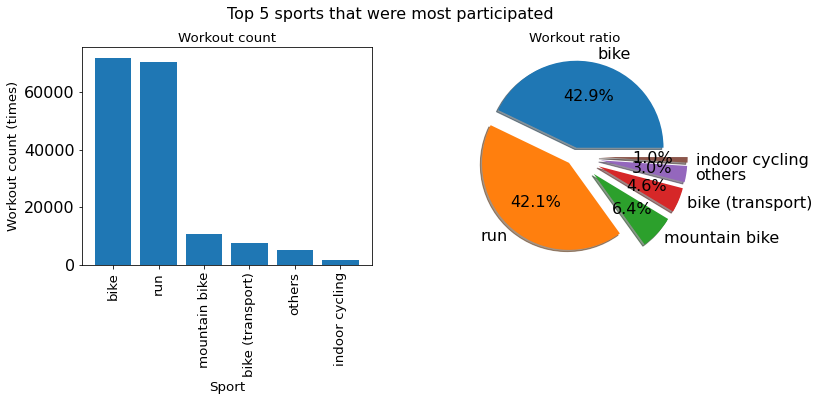

In [20]:
activities_by_gender_df = activities_by_gender.pivot_table(
    index="sport", columns="gender", values='count', fill_value=0).reset_index().rename_axis(None, axis=1)

activities_by_gender_df['total'] = activities_by_gender_df['male']+ activities_by_gender_df['female']+ activities_by_gender_df['unknown']
activities_by_gender_df['percentage'] = activities_by_gender_df['total']/ sum(activities_by_gender_df['total']) * 100
top_activities_by_gender_df = activities_by_gender_df.sort_values(
    by='percentage', ascending=False
).head(5)

others = {'sport' : 'others'}
for column in ['female', 'male', 'unknown', 'total', 'percentage']:
    value = sum(activities_by_gender_df[column]) - sum(top_activities_by_gender_df[column])
    others.update({column: value})
top_activities_by_gender_df = top_activities_by_gender_df.append(others, ignore_index=True)
top_activities_by_gender_df = top_activities_by_gender_df.sort_values(by='percentage', ascending=False)
top_activities_by_gender_df

#visualization
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 = axs[0].bar(x=top_activities_by_gender_df['sport']
                   , height=top_activities_by_gender_df['total'])
title0 = axs[0].set_title('Workout count', fontsize='small')
xlabel0 = axs[0].set_xlabel('Sport', fontsize='small')
ylabel0 = axs[0].set_ylabel('Workout count (times)', fontsize='small')
xsticks_label = axs[0].set_xticklabels(top_activities_by_gender_df['sport']
                                       , rotation='vertical', fontsize='small')
explode = (0.1, 0.1, 0.3, 0.3, 0.3, 0.3)
title1 = axs[1].set_title('Workout ratio', fontsize = 'small')
plot1 = axs[1].pie(
    x=top_activities_by_gender_df['percentage']
    , labels=top_activities_by_gender_df['sport']
    , autopct='%1.1f%%', shadow=True, explode=explode, radius=1
)

text = fig.text(0.5, 1.02, 'Top 5 sports that were most participated'
                , ha='center', va='top', transform=fig.transFigure)


In [23]:
min_number_of_sports = 1

sport_df = df \
    .select(df.userId, df.gender, df.sport) \
    .distinct() \
    .groupBy(df.userId, df.gender) \
    .count()    

user_more_sports_df = sport_df \
                    .filter(sport_df["count"] > min_number_of_sports) \
                    .orderBy("count", ascending = False) \
                    .toPandas()
user_more_sports_df.rename(columns = {'count':'Sports count'}, inplace = True)
user_more_sports_df.describe().astype(int).T


,count,mean,std,min,25%,50%,75%,max
userId,743,4808488,3949935,69,1612975,3700284,7415293,15481421
Sports count,743,3,1,2,2,3,4,12


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


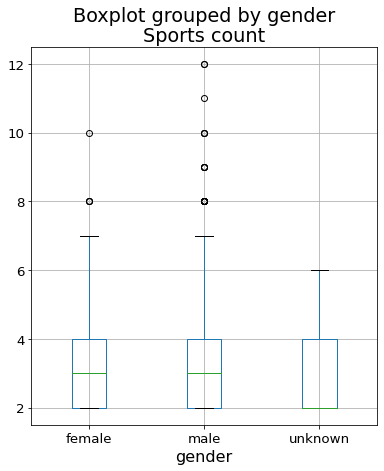

In [24]:
plot = user_more_sports_df.boxplot(column='Sports count', by='gender', fontsize='small', figsize=(6,7))


Plot of workouts distribution plot by activity type:


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/hist.py:428: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds,


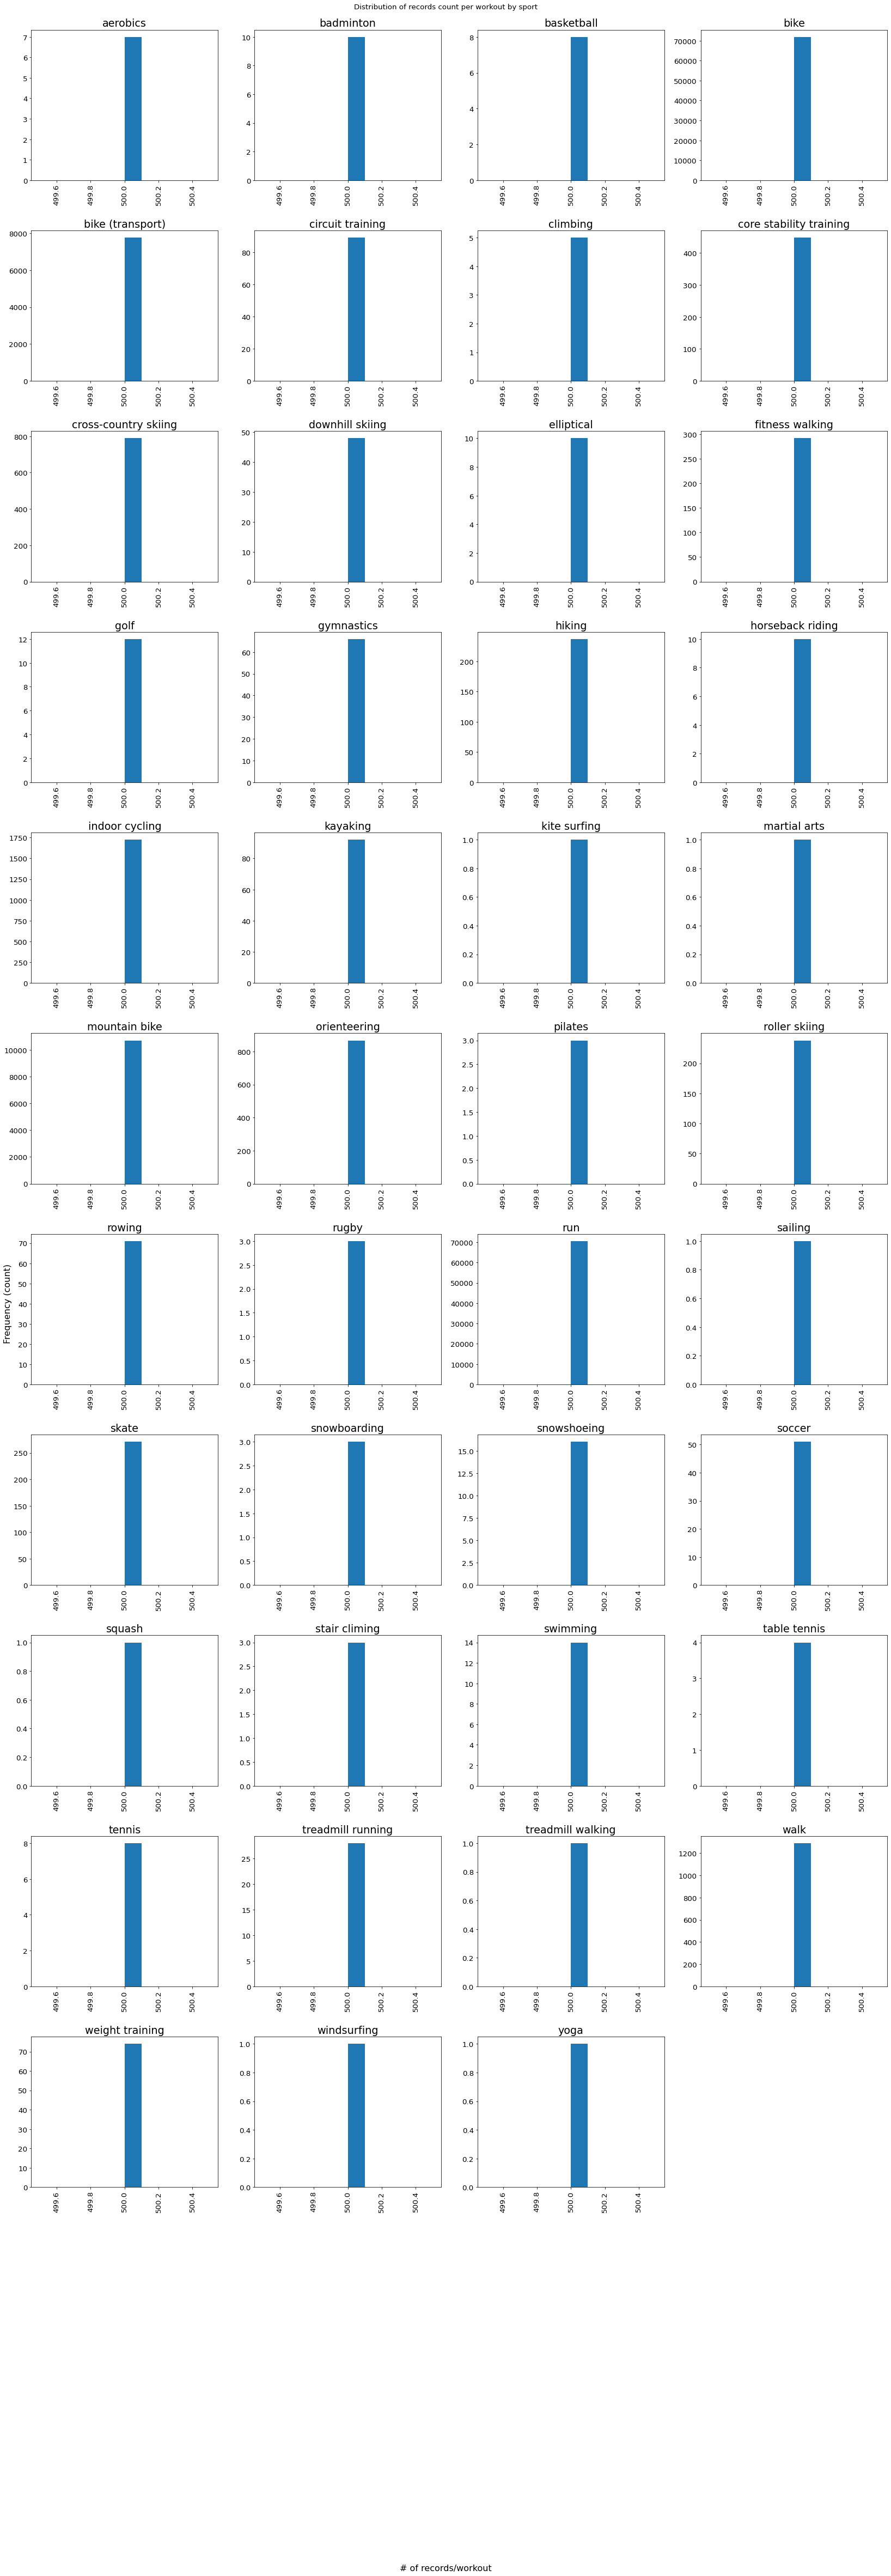

In [25]:
print('\nPlot of workouts distribution plot by activity type:')
plot_size_x, plot_size_y = 5, 5
figsize_x, figsize_y = plot_size_x * 4 + 3, plot_size_y * 13 + 1
figsize=(figsize_x, figsize_y)
fig = plt.figure(figsize=figsize) #
grid_size = (13,4)
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
#fig, ax = plt.subplots()
PerWorkoutRecordCount_dist = df.select('PerWorkoutRecordCount', 'sport').toPandas().hist(
    column='PerWorkoutRecordCount', bins=10, sharex = False, grid=True
    , xlabelsize='small', ylabelsize='small', by='sport', ax = ax
    , layout = grid_size, figsize=figsize)
a = fig.tight_layout()
title = fig.text(0.5, 1, 'Distribution of records count per workout by sport', ha='center', fontsize='small', transform=fig.transFigure)
xlabel = fig.text(0.5, 0.01, '# of records/workout', va='bottom', ha='center', transform=fig.transFigure)
ylabel = fig.text(0.01, 0.5, 'Frequency (count)', va='center', rotation='vertical')

In [28]:
# checking timestamp column
df.limit(3).toPandas()


,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId,PerWorkoutRecordCount
0,"[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....",male,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",396826535,"[60.173348765820265, 60.173239801079035, 60.17...","[24.64977040886879, 24.65014273300767, 24.6509...","[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...",bike,"[1408898746, 1408898754, 1408898765, 140889877...",https://www.endomondo.com/users/10921915/worko...,10921915,500
1,"[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....",male,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",392337038,"[60.173247596248984, 60.17320962622762, 60.172...","[24.649855233728886, 24.65015547350049, 24.650...","[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...",bike,"[1408221682, 1408221687, 1408221699, 140822170...",https://www.endomondo.com/users/10921915/worko...,10921915,500
2,"[76.4, 73.2, 72.4, 73.0, 73.0, 70.8, 69.2, 69....",male,"[99, 105, 113, 110, 109, 110, 108, 121, 116, 1...",389643739,"[60.17326201312244, 60.173205351457, 60.172969...","[24.64995657093823, 24.650197718292475, 24.651...","[4.0464, 13.8204, 16.9776, 19.9404, 28.7856, 3...",bike,"[1407858459, 1407858466, 1407858478, 140785849...",https://www.endomondo.com/users/10921915/worko...,10921915,500


In [29]:
# Filtering df with at least 10 records (as we are assumming if any user_id with less then 10 record would not be meaningful)
qualified_df = df.select(df.sport, df.userId, df.gender).groupBy(df.sport, df.userId, df.gender).count()
qualified_df = qualified_df.filter(qualified_df["count"] >= 10).orderBy("count", ascending = False)

In [30]:
print('Number of users having more than 10 workouts:')
qualified_pd_df = qualified_df.select("userId", "gender").distinct().groupBy(qualified_df.gender).count().toPandas()
qualified_pd_df.rename(columns={'count': 'Users count'}, inplace=True)
qualified_pd_df


qualified_users_count = sum(qualified_pd_df['Users count'])

total_users_count = df.select('userId').distinct().count()

qualified_percentage = round((qualified_users_count / total_users_count),2) * 100

print('\nSo there is {} / {} of users qualifying the 10 historical records criteria, which is {:.2f}%'.format(qualified_users_count, 
                                                                                                              total_users_count, qualified_percentage))

Number of users having more than 10 workouts:


,gender,Users count
0,unknown,13
1,female,78
2,male,853



So there is 944 / 1059 of users qualifying the 10 historical records criteria, which is 89.00%


In [32]:
#checking timestamp column
df.limit(3).toPandas()

,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId,PerWorkoutRecordCount
0,"[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....",male,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",396826535,"[60.173348765820265, 60.173239801079035, 60.17...","[24.64977040886879, 24.65014273300767, 24.6509...","[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...",bike,"[1408898746, 1408898754, 1408898765, 140889877...",https://www.endomondo.com/users/10921915/worko...,10921915,500
1,"[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....",male,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",392337038,"[60.173247596248984, 60.17320962622762, 60.172...","[24.649855233728886, 24.65015547350049, 24.650...","[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...",bike,"[1408221682, 1408221687, 1408221699, 140822170...",https://www.endomondo.com/users/10921915/worko...,10921915,500
2,"[76.4, 73.2, 72.4, 73.0, 73.0, 70.8, 69.2, 69....",male,"[99, 105, 113, 110, 109, 110, 108, 121, 116, 1...",389643739,"[60.17326201312244, 60.173205351457, 60.172969...","[24.64995657093823, 24.650197718292475, 24.651...","[4.0464, 13.8204, 16.9776, 19.9404, 28.7856, 3...",bike,"[1407858459, 1407858466, 1407858478, 140785849...",https://www.endomondo.com/users/10921915/worko...,10921915,500


##Extracting import features from timestamp column

In [33]:
# Convert a timestamp column into Datetime.Datetime, to be used for .withColumn function later
def to_time(timestamp_list):
    # convert to datetime and minus 7 hours due to the difference in Endomondo time window with utc time as the dataset description
    return [datetime.fromtimestamp(t) - timedelta(hours=7) for t in timestamp_list]

# Register 'to_time' function into UDF pyspark framework
udf_to_time = udf(to_time, ArrayType(elementType=TimestampType()))

# Support function to get the duration (in minutes) of a list of datetime values, to be used for withColumn function later
def get_duration(datetime_list):
    time_dif = max(datetime_list) - min(datetime_list)
    return time_dif.seconds/60

# Register the support function 'get_duration' as a user defined function into pyspark framework
udf_get_duration = udf(get_duration, FloatType())

# Support function to get the workout start time of the datetime list, to be used for withColumn function later
def get_start_time(datetime_list):
    return min(datetime_list)

# Register the support function 'get_start_time' as a user defined function into pyspark framework
udf_get_start_time = udf(get_start_time, TimestampType())

# Support function to get list of intervals within a workout
def get_interval(datetime_list):
    if len(datetime_list) == 1:
        return [0]
    else:
        interval_list = []
        for i in range(0, len(datetime_list)-1):
            interval = (datetime_list[i+1] - datetime_list[i]).seconds
            interval_list.append(interval)
        return interval_list

# Registering the support function 'get_interval' as a user defined function into pyspark framework    
udf_get_interval = udf(get_interval, ArrayType(elementType=IntegerType()))

# Creating new 'date_time' column to convert from timestamp into python's datetime format for later usage
df = df.withColumn('date_time', udf_to_time('timestamp'))

# Creating 'workout_start_time' column to get the start time of each workout/row:
df = df.withColumn('workout_start_time', hour(udf_get_start_time('date_time')))

# Creating duration column from the date_time column just created, using the udf function udf_get_duration defined above
df = df.withColumn('duration', udf_get_duration('date_time'))

# Creating interval column from the date_time column, using the udf function udf_get_interval defined above
df = df.withColumn('interval', udf_get_interval('date_time'))

print('New columns (''date_time'', ''workout_start_time'' in hour, ''duration'' in minutes & ''interval'' in seconds)\n, first 5 rows:')

df.select('timestamp','date_time', 'workout_start_time', 'duration', 'interval').limit(5).toPandas()

New columns (date_time, workout_start_time in hour, duration in minutes & interval in seconds)
, first 5 rows:


,timestamp,date_time,workout_start_time,duration,interval
0,"[1408898746, 1408898754, 1408898765, 140889877...","[2014-08-24 09:45:46, 2014-08-24 09:45:54, 201...",9,126.483330,"[8, 11, 13, 16, 6, 23, 16, 23, 29, 23, 24, 24,..."
1,"[1408221682, 1408221687, 1408221699, 140822170...","[2014-08-16 13:41:22, 2014-08-16 13:41:27, 201...",13,74.000000,"[5, 12, 8, 4, 5, 6, 4, 4, 5, 13, 7, 17, 4, 10,..."
2,"[1407858459, 1407858466, 1407858478, 140785849...","[2014-08-12 08:47:39, 2014-08-12 08:47:46, 201...",8,112.483330,"[7, 12, 12, 16, 6, 7, 16, 11, 19, 13, 17, 11, ..."
3,"[1407432042, 1407432048, 1407432056, 140743206...","[2014-08-07 10:20:42, 2014-08-07 10:20:48, 201...",10,75.316666,"[6, 8, 9, 4, 13, 4, 3, 4, 13, 10, 13, 13, 7, 1..."
4,"[1406909434, 1406909436, 1406909437, 140690943...","[2014-08-01 09:10:34, 2014-08-01 09:10:36, 201...",9,22.616667,"[2, 1, 1, 3, 2, 1, 4, 2, 1, 2, 1, 1, 2, 4, 4, ..."


In [34]:
#checking all columns
df.limit(3).toPandas()

,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId,PerWorkoutRecordCount,date_time,workout_start_time,duration,interval
0,"[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....",male,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",396826535,"[60.173348765820265, 60.173239801079035, 60.17...","[24.64977040886879, 24.65014273300767, 24.6509...","[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...",bike,"[1408898746, 1408898754, 1408898765, 140889877...",https://www.endomondo.com/users/10921915/worko...,10921915,500,"[2014-08-24 09:45:46, 2014-08-24 09:45:54, 201...",9,126.48333,"[8, 11, 13, 16, 6, 23, 16, 23, 29, 23, 24, 24,..."
1,"[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....",male,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",392337038,"[60.173247596248984, 60.17320962622762, 60.172...","[24.649855233728886, 24.65015547350049, 24.650...","[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...",bike,"[1408221682, 1408221687, 1408221699, 140822170...",https://www.endomondo.com/users/10921915/worko...,10921915,500,"[2014-08-16 13:41:22, 2014-08-16 13:41:27, 201...",13,74.00000,"[5, 12, 8, 4, 5, 6, 4, 4, 5, 13, 7, 17, 4, 10,..."
2,"[76.4, 73.2, 72.4, 73.0, 73.0, 70.8, 69.2, 69....",male,"[99, 105, 113, 110, 109, 110, 108, 121, 116, 1...",389643739,"[60.17326201312244, 60.173205351457, 60.172969...","[24.64995657093823, 24.650197718292475, 24.651...","[4.0464, 13.8204, 16.9776, 19.9404, 28.7856, 3...",bike,"[1407858459, 1407858466, 1407858478, 140785849...",https://www.endomondo.com/users/10921915/worko...,10921915,500,"[2014-08-12 08:47:39, 2014-08-12 08:47:46, 201...",8,112.48333,"[7, 12, 12, 16, 6, 7, 16, 11, 19, 13, 17, 11, ..."


In [35]:
#checking duration stats
df.select('duration').toPandas().describe().T


,count,mean,std,min,25%,50%,75%,max
duration,167783.0,89.157356,56.407284,8.316667,49.166668,71.466667,115.48333,1389.533325



Plotting distribution of duration per sport type:


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/hist.py:428: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds,


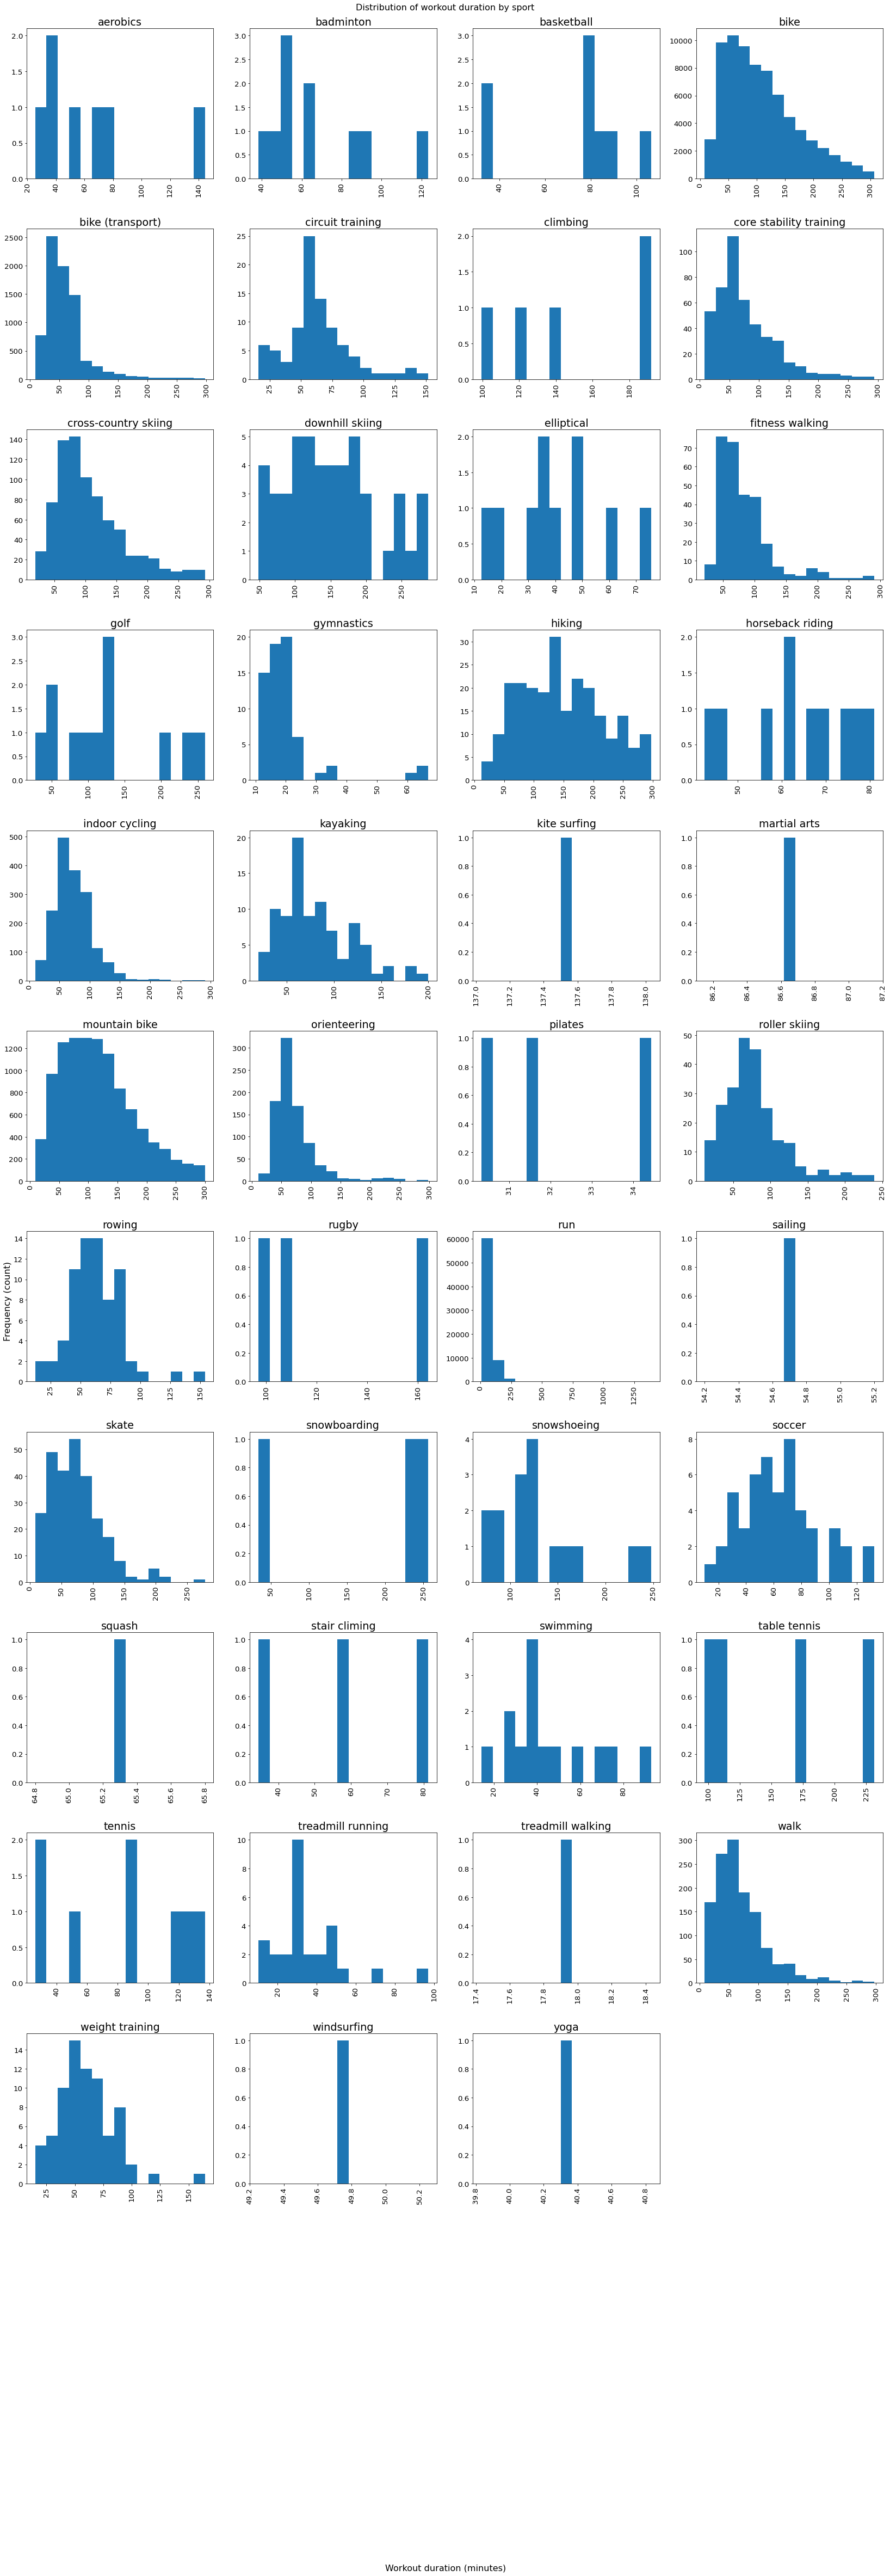

In [36]:
print('\nPlotting distribution of duration per sport type:')
plot_size_x, plot_size_y = 5, 5 

figsize_x, figsize_y = plot_size_x * 4 +3, plot_size_y * 13 + 1

figsize = (figsize_x, figsize_y)

fig = plt.figure(figsize=figsize)

grid_size = (13,4)

ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)

duration_dist = df.select('duration', 'sport').toPandas().hist(
    column='duration', by='sport', bins=15, sharex = False, grid=True
    , xlabelsize='small', ylabelsize='small' , ax = ax
    , layout = grid_size, figsize=figsize
    )

a = fig.tight_layout()

title = fig.text(0.5, 1, 'Distribution of workout duration by sport'
             , ha='center', va='center', transform=fig.transFigure
            )

xlabel = fig.text(0.5, 0.01, 'Workout duration (minutes)'
             , ha='center', va='center', transform=fig.transFigure)

ylabel = fig.text(0.01, 0.5, 'Frequency (count)', va='center', rotation='vertical')